<a href="https://colab.research.google.com/github/CalipsoAdara/SMN/blob/verif_S2/CHIRPS_cuenca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DESCARGA DE CHIRPS
Codigo para Restringir archivos CHIRPS a la cuenca de La Plata

*Correr luego de "**CHIRPS.py**"*

---
[CHIRPS DATA GLOBAL](https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/)


## Instalacion e importar librerias necesarias

In [ ]:
# instalar
!pip install regionmask   # restringir data
!pip install geopandas    # para leer shapefiles
!pip install xarray
!pip install cartopy
!pip install shapely==1.8.5
!pip install datetime
!pip install metpy
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 KB 810.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 4.4 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.
Looking in 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 32.8 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.3
    Uninstalling matplotlib-3.6.3:
      Successfully uninstalled matplotlib-3.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
metpy 1.4.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.


In [ ]:
# importar
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import osgeo.ogr
import geopandas as gpd
import regionmask

In [ ]:
# Montar drive
from google.colab import drive
drive.mount('/content/drive')
os.chdir('./drive/MyDrive/google_colab/EGFS')

Mounted at /content/drive


## Lectura de NETCDF por mes
Todos los años, todos los meses. Desde 1981 a 2022

In [ ]:
# Periodo
years = range(1981,2022+1)  # el +1 para que incluya el ultimo valor
meses = range(1,12+1)

# Nombre de los archivos
filelist = ["chirps-v2.0."+str(y) +"."+str(m)+".days_SA_down.nc" for y in years for m in meses]

## Como restringir el netcdf segun un shapefile
[Tutorial en YouTube](https://www.youtube.com/watch?v=RdAFsMhdMOY)

[Shapefiles - Cuenca de La Plata](http://www.cima.fcen.uba.ar/ClarisLPB/RDA_list.php?ti=ob&su=geo)


---



### *Primer paso*
Abrir el shapefile con geopandas. Recordar tener en la misma carpeta los archivos **".dbf"**, **".shx"** , **".sbx"**, **".sbn"** con el mismo nombre que el **".shp"**

In [ ]:
# Lee el archivo y lo convierte en un data frame
cuenca = gpd.read_file("./LaPlataBasin_border/cuenca del plata geog.shp")
cuenca

,ID,AREA,PERIMETER,ACRES,geometry
0,0,3100000.0,0.0,0.0,"POLYGON ((-67.01834 -22.07114, -67.00965 -22.0..."


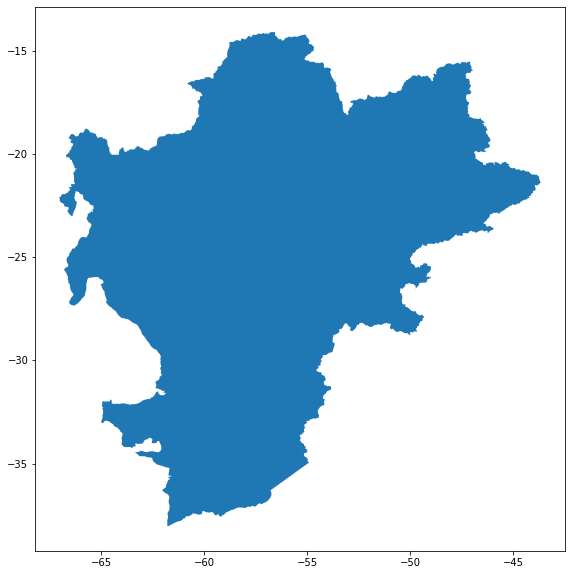

In [ ]:
# Graficar para comprobar el shapefile
fig, ax = plt.subplots(figsize=(16,10))
cuenca.plot(ax=ax)

### *Segundo paso*
Crear una mascara con regionmask. Elegir el nombre de columna del dataframe anterior. Outlines siempre son los valores de la geometria del poligono (en la columna "geometry")


En caso de haber mas de una division, chequear el video, donde usan el siguiente codigo para una lista de las divisiones.
```
# CODIGO AYUDA MEMORIA
countries_mask_poly = regionmask.Regions(name='NUTS_ID',
                        numbers=indexes, 
                        names = countries.NUTS_ID [indexes], abbrevs = countries.NUTS_ID[indexes], outlines = list(countries.geometry.values[i] for i in range(0,countries.shape[0]))) #outlines= countries['geometry'])
```



In [ ]:
# Creacion de Mascara de polygon
mask_poly = regionmask.Regions(name="AREA", outlines =cuenca.geometry.values)

### *Tercer paso*
Cargar un archivo NETCDF a restringir. Con el mismo se crea una mascará para todos los archivos de mismas dimensiones. Con crearlo una vez y guardarlo, sirve para todos.

Con la funcion "mask" se crea unas mascara con mask_poly y un dataarray. Recordar usar los nombres de latitud y longitud como se encuentran en el dataarray. También, utilizar solo un dia (time = 0).

In [ ]:
# Cargo NETCDF con XARRAY
ds = xr.open_dataarray("chirps-v2.0.2022.12.days_p05_SA_down.nc")

# Hacer la mascara segun el dataarray
mask= mask_poly.mask(ds.isel(time = 0),lat_name = "latitude",lon_name="longitude")

# guardar como netcdf
mask.to_netcdf("mask_by_LaPlata.nc")

In [ ]:
# Tomo los valores igual a 0
masked_shape = ds.where(mask==0)

  # GUardar 
masked_shape.to_netcdf("prubeaCHIRPS.nc")

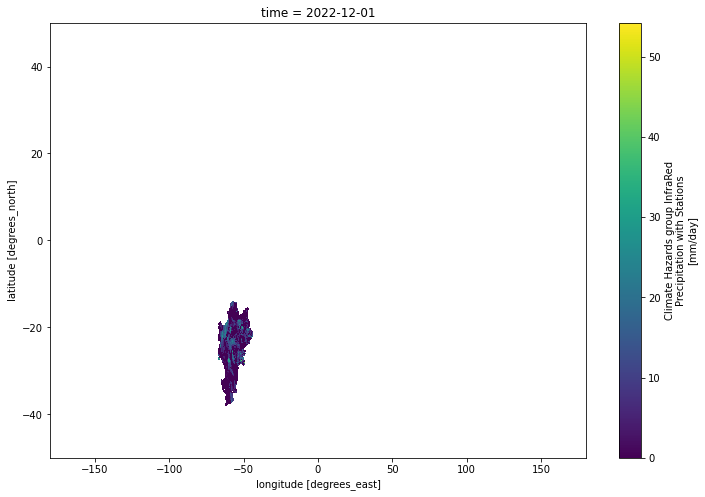

In [ ]:
masked_shape
  # Graficar (un dia)
plt.figure(figsize=(12,8))
ax = plt.axes()
masked_shape.isel(time=0).plot(ax=ax)
#cuenca.plot(ax=ax,alpha=0.8,facecolor = "none")

In [ ]:
type(masked_shape)

xarray.core.dataarray.DataArray

LISTO! 

Ahora se puede usar esa mascara para el resto de los archivos, al tener misma dimension espacial.



---


# Restriccion a todos los archivos


Utilizar un loop para restringir a la cuenca de La Plata

In [ ]:
# Leo la mascara
mask = xr.open_dataarray("mask_by_LaPlata.nc")

# Hago un loop en todos los archivos (dia, mes, año)
for f in filelist:

  # cargo el archivo
  ds = xr.open_dataarray(f)

  # Tomo los valores igual a 0
  masked_shape = ds.where(mask==0)

  # GUardar 
  masked_shape.to_netcdf("prubea.nc")


  # Graficar (un dia)
  plt.figure(figsize=(12,8))
  ax = plt.axes()
  masked_shape.isel(time=0).plot(ax=ax)
  cuenca.plot(ax=ax,alpha=0.8,facecolor = "none")

  plt.savefig('books_read.png')
  